In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yahoo-stock-csv/yahoo_stock.csv


In [2]:
# Johann Estrada Pox & Tim Luhmann

# Importierung von benötigten Bibliotheken 
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler


tf.random.set_seed(7)

# Einlesen des Datensatzes von der CSV-Datei
df = pd.read_csv('/kaggle/input/yahoo-stock-csv/yahoo_stock.csv')

# Date Spalte als Datum festlegen
df['Date'] = pd.to_datetime(df["Date"])
# 'Date', 'Close', 'High', 'Low' und 'Open' werden für für den Datensatz ausgewählt
df = df.loc[: , ['Date', 'Close', 'High', 'Low', 'Open']]
# Anzeigen der ersten fünf Einträge
df.head()

,Date,Close,High,Low,Open
0,2015-11-23,2086.590088,2095.610107,2081.389893,2089.409912
1,2015-11-24,2089.139893,2094.120117,2070.290039,2084.419922
2,2015-11-25,2088.870117,2093.000000,2086.300049,2089.300049
3,2015-11-26,2088.870117,2093.000000,2086.300049,2089.300049
4,2015-11-27,2090.110107,2093.290039,2084.129883,2088.820068


In [3]:
print(df.describe())

print(df.info())

                      Date        Close         High          Low         Open
count                 1825  1825.000000  1825.000000  1825.000000  1825.000000
mean   2018-05-23 00:00:00  2647.856284  2660.718673  2632.817580  2647.704751
min    2015-11-23 00:00:00  1829.079956  1847.000000  1810.099976  1833.400024
25%    2017-02-21 00:00:00  2328.949951  2348.350098  2322.250000  2341.979980
50%    2018-05-23 00:00:00  2683.340088  2696.250000  2667.840088  2685.489990
75%    2019-08-22 00:00:00  2917.520020  2930.790039  2900.709961  2913.860107
max    2020-11-20 00:00:00  3626.909912  3645.989990  3600.159912  3612.090088
std                    NaN   407.301177   409.680853   404.310068   407.169994
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1825 non-null   datetime64[ns]
 1   Close   1825 non-null   float64       
 2   Hi

In [4]:
# Zeigen der Form der Daten
print(df.shape)

print(df.isnull().values.any())

(1825, 5)
False


In [5]:
# Zeitbezogene Merkmale
def create_date_features(df):
    df['month'] = df.Date.dt.month.astype("int8")  # Monat
    df['day_of_month'] = df.Date.dt.day.astype("int8")  # Tag des Monats
    df['day_of_year'] = df.Date.dt.dayofyear.astype("int16")  # Tag des Jahres
    df['week_of_month'] = (df.Date.apply(lambda d: (d.day-1) // 7 + 1)).astype("int8")  # Woche des Monats
    #df['week_of_year'] = (df.Date.dt.weekofyear).astype("int8")  # Woche des Jahres
    df['day_of_week'] = (df.Date.dt.dayofweek + 1).astype("int8")  # Wochentag
    df['year'] = df.Date.dt.year.astype("int32")  # Jahr
    df["is_wknd"] = (df.Date.dt.weekday // 4).astype("int8")  # Wochenende
    df["quarter"] = df.Date.dt.quarter.astype("int8")  # Quartal
    df['is_month_start'] = df.Date.dt.is_month_start.astype("int8")  # Monatsanfang
    df['is_month_end'] = df.Date.dt.is_month_end.astype("int8")  # Monatsende
    df['is_quarter_start'] = df.Date.dt.is_quarter_start.astype("int8")  # Quartalsanfang
    df['is_quarter_end'] = df.Date.dt.is_quarter_end.astype("int8")  # Quartalsende
    df['is_year_start'] = df.Date.dt.is_year_start.astype("int8")  # Jahresanfang
    df['is_year_end'] = df.Date.dt.is_year_end.astype("int8")  # Jahresende
    # 0: Winter - 1: Frühling - 2: Sommer - 3: Herbst
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)  # Jahreszeit bestimmen
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])  # Sommer
    df["season"] = pd.Series(np.where(df.month.isin([9, 10, 11]), 3, df["season"])).astype("int8")  # Herbst
    return df

In [6]:
# Anwenden der vorher definierten Funktion auf den Datensatz df
temp = create_date_features(df)
# Anzeigen der ersten fünf Einträge
temp.head()

,Date,Close,High,Low,Open,month,day_of_month,day_of_year,week_of_month,day_of_week,year,is_wknd,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season
0,2015-11-23,2086.590088,2095.610107,2081.389893,2089.409912,11,23,327,4,1,2015,0,4,0,0,0,0,0,0,3
1,2015-11-24,2089.139893,2094.120117,2070.290039,2084.419922,11,24,328,4,2,2015,0,4,0,0,0,0,0,0,3
2,2015-11-25,2088.870117,2093.000000,2086.300049,2089.300049,11,25,329,4,3,2015,0,4,0,0,0,0,0,0,3
3,2015-11-26,2088.870117,2093.000000,2086.300049,2089.300049,11,26,330,4,4,2015,0,4,0,0,0,0,0,0,3
4,2015-11-27,2090.110107,2093.290039,2084.129883,2088.820068,11,27,331,4,5,2015,1,4,0,0,0,0,0,0,3


In [7]:
# Importieren von weiteren wichtigen Bibliotheken

import seaborn as sns
import math

from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess, Fourier

In [8]:
# Fourier-Transformation und deterministischer Prozess, um saisonale und trendbezogene Zeitfeatures zu generieren und diese mit den Originaldaten zu kombinieren, um die Modellierung zeitabhängiger Muster zu verbessern.
fourier = CalendarFourier(freq = 'Y', order = 3)  # Fourier-Transformation für saisonale Komponenten 'Y' steht für jährlich, 'order=3' gibt die Anzahl der Fourier-Terme an
dp = DeterministicProcess(index = temp.Date,
                          order = 1,  # lineare Trendkomponente
                          seasonal = False,  # Keine Saisonalität, da dies durch die Fourier-Terme abgedeckt wird
                          constant = False,  # Keine Konstante hinzufügen
                          additional_terms = [fourier],  # Hinzufügen von Fourier-Termen für die Saisonalität
                          drop = True)  # Dropt Originalterme
time = dp.in_sample()  # Generiert deterministische Zeitfeatures (regelmäßige Muster in Zeitreihendaten)

time = time.reset_index()  # Index zurücksetzen, um 'Date' als normale Spalte zu haben

temp_join = pd.merge(temp, time, how='inner', left_on='Date', right_on='Date')  # Zusammenführen von Original- und Zeitfeatures basierend auf der 'Date'-Spalte
print(temp_join.shape)  # Ausgabe der Dimensionen von 'temp_join'

temp_join.head()  # Anzeigen der ersten Zeilen von 'temp_join'

(1825, 27)


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


,Date,Close,High,Low,Open,month,day_of_month,day_of_year,week_of_month,day_of_week,...,is_year_start,is_year_end,season,trend,"sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(2,freq=YE-DEC)","cos(2,freq=YE-DEC)","sin(3,freq=YE-DEC)","cos(3,freq=YE-DEC)"
0,2015-11-23,2086.590088,2095.610107,2081.389893,2089.409912,11,23,327,4,1,...,0,0,3,1.0,-0.622047,0.782980,-0.974100,0.226116,-0.903356,-0.428892
1,2015-11-24,2089.139893,2094.120117,2070.290039,2084.419922,11,24,328,4,2,...,0,0,3,2.0,-0.608477,0.793572,-0.965740,0.259512,-0.924291,-0.381689
2,2015-11-25,2088.870117,2093.000000,2086.300049,2089.300049,11,25,329,4,3,...,0,0,3,3.0,-0.594727,0.803928,-0.956235,0.292600,-0.942761,-0.333469
3,2015-11-26,2088.870117,2093.000000,2086.300049,2089.300049,11,26,330,4,4,...,0,0,3,4.0,-0.580800,0.814046,-0.945596,0.325342,-0.958718,-0.284359
4,2015-11-27,2090.110107,2093.290039,2084.129883,2088.820068,11,27,331,4,5,...,0,0,3,5.0,-0.566702,0.823923,-0.933837,0.357698,-0.972118,-0.234491


In [9]:
# Importieren von weiteren wichtigen Bibliotheken

from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [10]:
temp_join = temp_join.set_index(['Date'])  # Setzt 'Date' als Index
temp_join.head(3)  # Zeigt die ersten 3 Zeilen von 'temp_join' an

,Close,High,Low,Open,month,day_of_month,day_of_year,week_of_month,day_of_week,year,...,is_year_start,is_year_end,season,trend,"sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(2,freq=YE-DEC)","cos(2,freq=YE-DEC)","sin(3,freq=YE-DEC)","cos(3,freq=YE-DEC)"
Date,,,,,,,,,,,,,,,,,,,,,
2015-11-23,2086.590088,2095.610107,2081.389893,2089.409912,11,23,327,4,1,2015,...,0,0,3,1.0,-0.622047,0.782980,-0.974100,0.226116,-0.903356,-0.428892
2015-11-24,2089.139893,2094.120117,2070.290039,2084.419922,11,24,328,4,2,2015,...,0,0,3,2.0,-0.608477,0.793572,-0.965740,0.259512,-0.924291,-0.381689
2015-11-25,2088.870117,2093.000000,2086.300049,2089.300049,11,25,329,4,3,2015,...,0,0,3,3.0,-0.594727,0.803928,-0.956235,0.292600,-0.942761,-0.333469


In [11]:
# Festlegung der größe des Train- und Testdatensatzes

train_size = int(0.85 * len(temp_join))
test_size = len(temp_join) - train_size

In [12]:
# Aufteilung in Train- und Testdatensatz
train_set, test_set = temp_join.iloc[:-test_size, :], temp_join.iloc[-test_size: , :]
train_set.shape, test_set.shape

((1551, 26), (274, 26))

In [13]:
# Skalieren der Daten mittels MinMaxScaler auf Werte zwischen -1 und 0

scaler = MinMaxScaler(feature_range=(-1, 0))

train_scaled = scaler.fit_transform(train_set)
test_scaled = scaler.transform(test_set)

train_scaled.shape, test_scaled.shape

((1551, 26), (274, 26))

In [14]:
scaled_data = np.append(train_scaled, test_scaled, axis=0)  # Kombiniert skalierte Train- und Testdaten
scaled_data.shape  # Gibt die Form von 'scaled_data' aus

(1825, 26)

In [15]:
train_size = train_set.shape[0]  # Anzahl der Trainingsdaten
test_size = test_set.shape[0]  # Anzahl der Testdaten

# Festlegung der Anzahl der Tage für die Vorhersage
look_back = 20
# Aufteilung in Train- und Testset
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)): # Schleife über dataset beginnend bei 'look_back'
        a = dataset[i-look_back:i, 0] # Sequenz von look_back vor dem aktuellen Zeitschritt i
        X.append(a) # hinzufügen von a zur Liste X
        Y.append(dataset[i, 0]) # Der Wert im Dataset am aktuellen Zeitschritt i
    return np.array(X), np.array(Y) # Umwandlung in numpy-Arrays

x_train, y_train = create_dataset(train, look_back)  # Erstellen des Trainingsdatensatzes
x_test, y_test = create_dataset(test, look_back)  # Erstellen des Testdatensatzes

# Umformung der Eingabe in [Samples, Zeitschritte, Features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))  # Umformung der Trainingsdaten
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))  # Umformung der Testdaten

print(len(x_train), len(x_test))  # Ausgabe der Länge der Trainings- und Testdaten
print(x_train)
print(y_train)

1511 274
[[[-0.83461878 -0.83298121 -0.83315447 ... -0.85668593 -0.88228529
   -0.88228529]]

 [[-0.83298121 -0.83315447 -0.83315447 ... -0.88228529 -0.88228529
   -0.88228529]]

 [[-0.83315447 -0.83315447 -0.83235811 ... -0.88228529 -0.88228529
   -0.87613916]]

 ...

 [[-0.07157671 -0.07758149 -0.07758149 ... -0.05823755 -0.0915309
   -0.07058765]]

 [[-0.07758149 -0.07758149 -0.07758149 ... -0.0915309  -0.07058765
   -0.07241165]]

 [[-0.07758149 -0.07758149 -0.06295158 ... -0.07058765 -0.07241165
   -0.06582234]]]
[-0.88228529 -0.87613916 -0.86235039 ... -0.07241165 -0.06582234
 -0.10316164]


In [16]:
# Aufbau des LSTM-Modells
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))  # Erste LSTM-Schicht mit 256 Neuronen
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))  # Leaky ReLU Aktivierungsfunktion
model.add(LSTM(128, return_sequences=True))  # Zweite LSTM-Schicht mit 128 Neuronen
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))  # Leaky ReLU Aktivierungsfunktion
model.add(tf.keras.layers.Dropout(0.20))  # Dropout-Schicht mit 20% Rate
model.add(LSTM(64, return_sequences=False))  # Dritte LSTM-Schicht mit 64 Neuronen
model.add(tf.keras.layers.Dropout(0.20))  # Dropout-Schicht mit 20% Rate
model.add(Dense(25))  # Dense-Schicht mit 25 Neuronen
model.add(Dense(1))  # Ausgabeschicht mit 1 Neuron

model.summary()  # Zusammenfassung des Modells

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 256)         │       283,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 531,827 (2.03 MB)

 Trainable params: 531,827 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Earlystopping, um overfitting zu vermeiden
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')

# Kompilierung des Modells
model.compile(optimizer=tf.optimizers.Adamax(), 
              loss=tf.losses.MeanAbsolutePercentageError(), 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [18]:
from keras.callbacks import LearningRateScheduler

# lr_schedule definieren
def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.5  
    return lr

# Callback erstellen
lr_callback = LearningRateScheduler(lr_scheduler)

# Training des LSTM-Netzwerkes
model.fit(x_train, y_train, batch_size=1, epochs=100, validation_data=(x_test, y_test),
         callbacks=[earlystopping, lr_callback])

Epoch 1/100
1511/1511 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 19.2653 - root_mean_squared_error: 0.1198 - val_loss: 106.5640 - val_root_mean_squared_error: 0.0764 - learning_rate: 0.0010
Epoch 2/100
1511/1511 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 9.8322 - root_mean_squared_error: 0.0645 - val_loss: 96.5846 - val_root_mean_squared_error: 0.0597 - learning_rate: 0.0010
Epoch 3/100
1511/1511 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 8.5006 - root_mean_squared_error: 0.0564 - val_loss: 71.3938 - val_root_mean_squared_error: 0.0527 - learning_rate: 0.0010
Epoch 4/100
1511/1511 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 7.8254 - root_mean_squared_error: 0.0532 - val_loss: 87.7952 - val_root_mean_squared_error: 0.0480 - learning_rate: 0.0010
Epoch 5/100
1511/1511 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 7.3459 - root_mean_squared_error: 0.0504 - val_loss: 91.7000 - val_root_mean_squared_error: 0.0460 - learning_rate: 0.0010


In [19]:
# Vorhersagen mit dem Modell
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


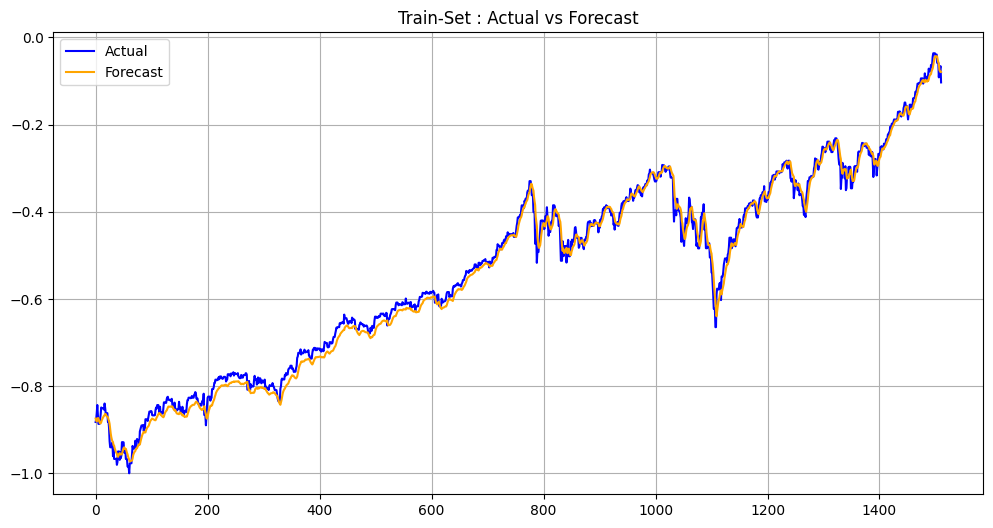

In [20]:
# Plotten der Performance am Train-Set

import matplotlib.pyplot as plt

plt.figure(figsize = (12 , 6))
plt.plot(y_train , 'b' , label = 'Actual')
plt.plot(np.array(train_predict).squeeze() , 'orange' , label = 'Forecast')
plt.grid()
plt.legend()
plt.title("Train-Set : Actual vs Forecast")
plt.show()

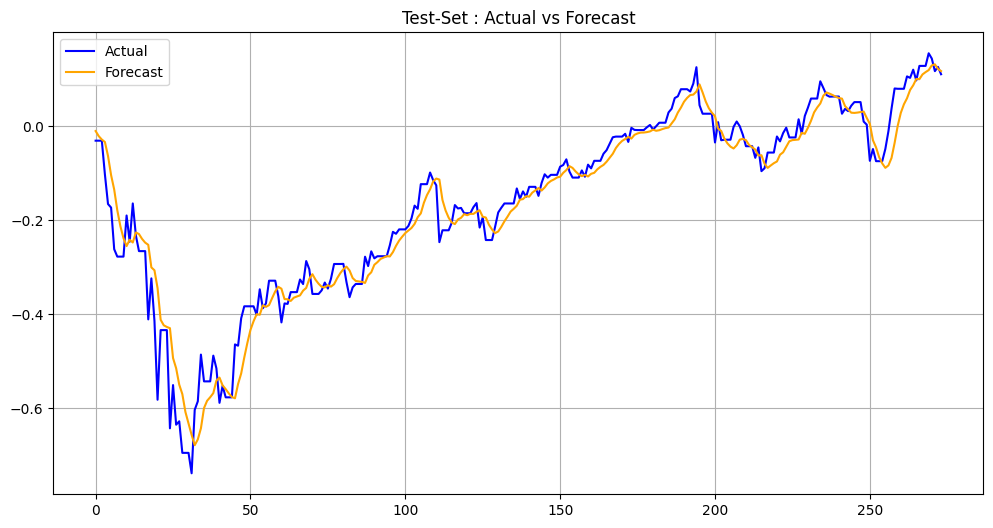

In [21]:
# Plotten der Performance am Test-Set

plt.figure(figsize = (12 , 6))
plt.plot(y_test , 'b' , label = 'Actual')
plt.plot(np.array(test_predict).squeeze() , 'orange' , label = 'Forecast')
plt.grid()
plt.legend()
plt.title("Test-Set : Actual vs Forecast")
plt.show()

In [22]:
# Ausgabe des RMSE (Root Mean Square Error) für Test- und Trainingsdaten

print(f'The RMSE for test set is {round(mean_squared_error(y_test, np.array(test_predict).squeeze(), squared=False), 2)}')
print('\n')
print(f'The RMSE for train set is {round(mean_squared_error(y_train, np.array(train_predict).squeeze(), squared=False), 2)}')

The RMSE for test set is 0.05


The RMSE for train set is 0.02
